In [ ]:
import pandas as pd
# ^^^ pyforest auto-imports - don't write above this line

In [1]:
data_subset = pd.read_csv('final_dataset_b2b_random_subset_churn.csv')

/Users/tabeaherbst/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


<IPython.core.display.Javascript object>

In [1]:
data = pd.read_csv('final_dataset_b2b_remaining_clients.csv')

/Users/tabeaherbst/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


<IPython.core.display.Javascript object>

In [4]:
data_merged = pd.merge(data, data_subset, on='client_id', how='left')

##### Identifying the churn dates of the customer that have churned

In [3]:
# Identify churned clients and their latest churn date within the first 50 weeks
churned_clients = data_merged[data_merged['churned'] == 1]
latest_churn_dates = churned_clients.groupby('client_id')['date_order'].max()

# Create a dictionary from the latest_churn_dates
churn_dates_dict = latest_churn_dates.to_dict()

# Map the churn dates back to the original dataframe using client_id
data_merged['churn_date'] = data_merged['client_id'].map(churn_dates_dict)

##### Extracting clients that have purchased something within 2019

In [4]:
### 2019 customers
data_merged['date_order'] = pd.to_datetime(data_merged['date_order'])

# Filter clients based on the year 2019
clients_50_week_2019 = data_merged[data_merged['date_order'].dt.year == 2019]

# Create a new DataFrame with only the relevant clients
clients_50_week = clients_50_week_2019.copy()

<IPython.core.display.Javascript object>

##### Only including clients that haven't churned or that have churned in the first 50 weeks

In [5]:
# Filter clients who have churned and their latest date_order is within the first 50 weeks
churned_clients = clients_50_week[clients_50_week['churned'] == 1]
latest_churn_dates = churned_clients.groupby('client_id')['date_order'].max().reset_index()
valid_churned_clients = latest_churn_dates[latest_churn_dates['date_order'] <= clients_50_week['date_order'].min() + pd.Timedelta(weeks=50)]

# Include clients who haven't churned
non_churned_clients = clients_50_week[clients_50_week['churned'] == 0]

# Concatenate both groups to create the new dataframe
retention_50_week = pd.concat([non_churned_clients, valid_churned_clients.merge(clients_50_week, on=['client_id', 'date_order'], how='inner')])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Calculate Retention Curve

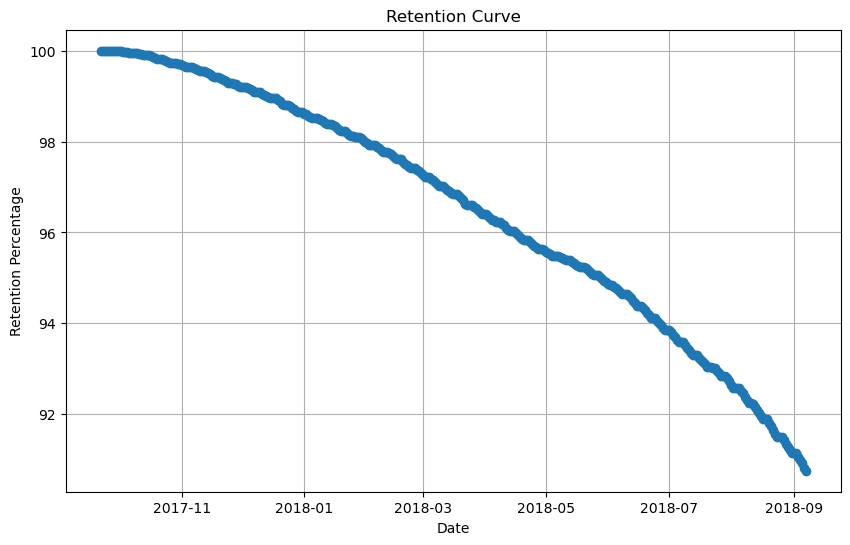

In [67]:
# Convert 'churn_date' to datetime if it's not already
retention_50_week['churn_date'] = pd.to_datetime(retention_50_week['churn_date'])

# Get the minimum date_order as the starting point
start_date = retention_50_week['date_order'].min()

# Calculate the total number of unique clients
number_of_unique_clients = len(retention_50_week['client_id'].unique())

# Calculate the percentage per client
percentage_per_client = 100 * 1 / number_of_unique_clients

# Create a list to store the retention curve data
retention_curve_data = []

# Iterate over each day starting from the minimum date
current_date = start_date
while current_date <= retention_50_week['date_order'].max():
    # Calculate the retention percentage for the current date
    retention_percentage = 100 - (percentage_per_client * retention_50_week[retention_50_week['churn_date'] <= current_date]['client_id'].nunique())
    
    # Append data to the list
    retention_curve_data.append({'Date': current_date, 'Retention': retention_percentage})
    
    # Move to the next day
    current_date += pd.Timedelta(days=1)

# Create a DataFrame from the list
retention_curve_df = pd.DataFrame(retention_curve_data)

# Plot the retention curve
plt.figure(figsize=(10, 6))
plt.plot(retention_curve_df['Date'], retention_curve_df['Retention'], marker='o')
plt.title('Retention Curve')
plt.xlabel('Date')
plt.ylabel('Retention Percentage')
plt.grid(True)
plt.show()


In [72]:
retention_50_week.head()

,date_order,date_invoice,product_id,client_id,sales_net,quantity,branch_id,product_price,order_channel_at the store,order_channel_by phone,...,order_channel_online,order_channel_other,time_diff,mean_purchase_frequency_days,cluster,latest_purchase_days,frequency_group,churned,churn_date,time_difference
23,2018-05-10,2018-05-10,1954776,6,550.216488,101,8470,5.447688,0,1,...,0,0,194 days,56,2,40,2,0.0,NaT,NaN
24,2018-05-10,2018-05-10,2512504,6,0.000000,3,8470,0.000000,0,1,...,0,0,0 days,56,2,40,2,0.0,NaT,NaN
25,2018-05-10,2018-05-10,184293,6,7.418880,21,8470,0.353280,0,1,...,0,0,0 days,56,2,40,2,0.0,NaT,NaN
26,2018-05-10,2018-05-10,1203365,6,14.837760,21,8470,0.706560,0,1,...,0,0,0 days,56,2,40,2,0.0,NaT,NaN
27,2018-03-30,2018-03-30,2004688,6,265.502187,31,8470,8.564587,0,1,...,0,0,41 days,56,2,40,2,0.0,NaT,NaN


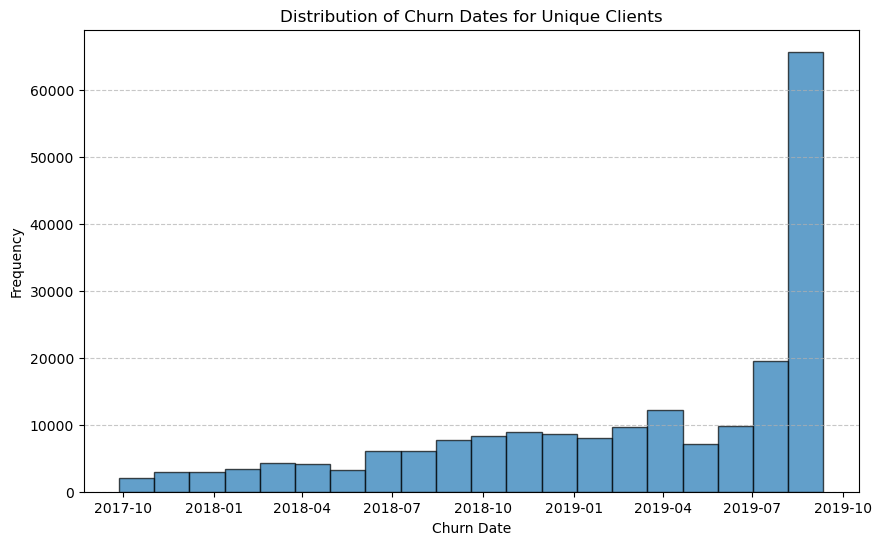

In [70]:
retention_50_week['churn_date'] = pd.to_datetime(retention_50_week['churn_date'])
retention_50_week['date_order'] = pd.to_datetime(retention_50_week['date_order'])

# Identify churned customers
churned_customers = retention_50_week[retention_50_week['churned'] == 1]

# Plot the distribution of churn dates for unique clients
plt.figure(figsize=(10, 6))
plt.hist(churned_customers['churn_date'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of Churn Dates for Unique Clients')
plt.xlabel('Churn Date')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()